In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import minimize
import scipy.io as scio
from scipy.integrate import odeint
# 设置随机数种子
np.random.seed(0)
# 加载数据设置分割点
data = pd.read_excel('./LuxembourgT.xlsx')
V = data['ww']
split = 78 #分割接种疫苗第一天后一周（2020/11/12）
V = V[:split]
V = np.squeeze(V)
tspan = list(range(1, len(V)+1))

In [7]:
import statistics
V=data['ww']
V = V.replace(-1, np.nan)
V[0]=0
V = V.interpolate(method='linear')
V1=V[:313]
V2=V[313:]
V=V1
V=[i for i in V]
split = 78

V = V[:split]
median = statistics.median(V)
V = np.squeeze(V)
tspan = list(range(1, len(V)+1))
print(median)

91775438596.49124


In [8]:
#设置模型参数初始值和上下界
options = {'maxiter': 50000, 'maxfev': 100000, 'disp': False, 'xtol': 1e-12, 'ftol': 1e-12}

beta_fixed = 4.48526e7#363952380952  91775438596 4.48526e7
lb = np.array([0, 51, beta_fixed-1, 10])
ub = np.array([1e-4, 796, beta_fixed, 5000])
p0 = np.array([9.06e-08, 360, beta_fixed, 1182])

In [9]:
def getDecay(t):
    """
    计算病毒RNA温度调整后的衰减率
    参数:
    t (float): 时间点
    返回:
    k (float): 衰减率
    """
    # 高病毒载量 -> tau0 = 0.99 days * 24 hours/day = 23.76
    # 低病毒载量  -> tau0 = 7.9 days * 24 hours/day  = 189.6
    tau0 = 189.6  # 23.76
    Q0 = 2.5
    T0 = 20

    #使用最佳拟合正弦函数获取当前温度
    A = 7.90326222
    B = 0.01654095
    C = 0.90602343
    D = 9.88969982

    T = A * np.sin(B * t - C) + D

    tau = tau0 * Q0 ** (-(T - T0) / 10)

    k = np.log(2) / tau

    return k

In [10]:
def SEIRV(t, y, param):
    """
    用于描述COVID-19的传播动力学的SEIR-V模型
    参数:
    t (float): 时间。
    y (numpy.ndarray): 状态变量 [S, E, I, R, V, E_cum]
    S: 易感人群
    E: 潜伏者
    I: 感染者
    R: 康复者
    V: 污水病毒载量
    param (numpy.ndarray): 模型参数 [lambda, alpha, beta]。
    lambda: 感染率
    alpha: 病毒负荷
    beta: 病毒脱落率
    返回值:
    dy (numpy.ndarray): 状态变量对时间的导数。这些导数描述了各状态变量随时间的变化率。
    """
    lambda_param = param[0]
    alpha = param[1]
    beta = param[2]

    dy = np.zeros(6)
    
    S=y[0]
    E=y[1]
    I=y[2]
    R=y[3]
    V=y[4]
    
    
    traveltime = 18
    k = getDecay(t)

    eta = 1 - np.exp(-k * traveltime)

    sigma = 1/3 #1/3 0.44
    gamma = 1/8#1/8 0.32
    #拟合SEIR-V的参数方程
    dy[0] = -lambda_param * S * I
    dy[1] = lambda_param * S * I - sigma * E
    dy[2] = sigma * E - gamma * I
    dy[3] = gamma * I
    dy[4] = alpha * beta * (1 - eta) * I
    dy[5] = lambda_param * S * I  

    return dy

In [11]:
def obj_fun(param, tspan, data):
    '''
    计算模型预测的病毒日增量与真实值之间的差异，并将其作为优化的目标函数
    过程：
    使用ode求解器求解SEIR-V模型，得到时间序列的状态变量Y
    从Y中提取累计病毒量，计算出日增病毒量（dailyVirus）
    adiff计算预测值和真实值之间的差异
    返回差异的平方和(float)
    '''
    traveltime = 18 #病毒 RNA 排泄后到达废水处理厂所需的时间
    
    k = getDecay(1)#衰减系数 

    eta = 1 - np.exp(-k * traveltime)#真正的衰减系数
    
    # 总人口
    N0 = 650000
    
    #设置模型初始值
    E0 = param[3]
    I0 = data[0] / (param[1] * param[2] * (1 - eta))
    R0 = 0
    S0 = N0 - (E0 + I0 + R0)
    V0 = data[0]
    
    ICs = [S0, E0, I0, R0, V0, E0]
    
    #ode求解SEIRV模型，得到状态变量Y
    solver = ode(SEIRV)
    solver.set_initial_value(ICs, tspan[0])
    solver.set_f_params(param[:3])
    Y = []
    t = []
    while solver.successful() and solver.t <= tspan[-1]:
        solver.integrate(solver.t + 1)
        Y.append(solver.y)
        t = solver.t
    # 计算病毒日增量
    #cumVirus = Y[:,4]
    cumVirus = [array_[4] for array_ in Y]
    dailyVirus = np.diff(cumVirus)
    #返回差异值的平方和 
    temp = np.log10(V[1:]) - np.log10(np.abs(dailyVirus))
    adiff = temp[~np.isnan(temp)]
    err = np.sum(adiff ** 2)
    print(err)
    return err

In [12]:
import numpy as np
from scipy.optimize import minimize, least_squares
from scipy.integrate import ode
# 进行全局搜索
res = least_squares(obj_fun, p0, bounds=(lb, ub), args=(tspan, V))

best_params = res.x
SSE = res.fun
print('最佳拟合参数:',best_params)
print('SSE:',SSE)
# 使用最佳参数进行拟合
alpha = best_params[1]
beta = best_params[2]
E0 = best_params[3]

traveltime = 18
k = getDecay(1)
eta = 1 - np.exp(-k * traveltime)

N0 = 650000
I0 = V[0] / (alpha * beta * (1 - eta))
R0 = 0
S0 = N0 - (E0 + I0 + R0)
V0 = V[0]
ICs = [S0, E0, I0, R0, V0, E0]

r = ode(SEIRV)
r.set_initial_value(ICs, 1)
r.set_f_params(best_params)
Y = []
t = []
while r.successful() and r.t <= len(V1):
    r.integrate(r.t + 1)
    Y.append(r.y)
    t = r.t

157.24920596597042
177.6181126506527
157.2491818022219
157.2491905654464
157.24918824787133
115.51234811642713
122.48818726412713
115.51234819806675
115.51234129570146
115.51233051889916
最佳拟合参数: [3.99165760e-08 3.60000001e+02 4.48526000e+07 1.18200000e+03]
SSE: [115.51234812]


d:\Anaconda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

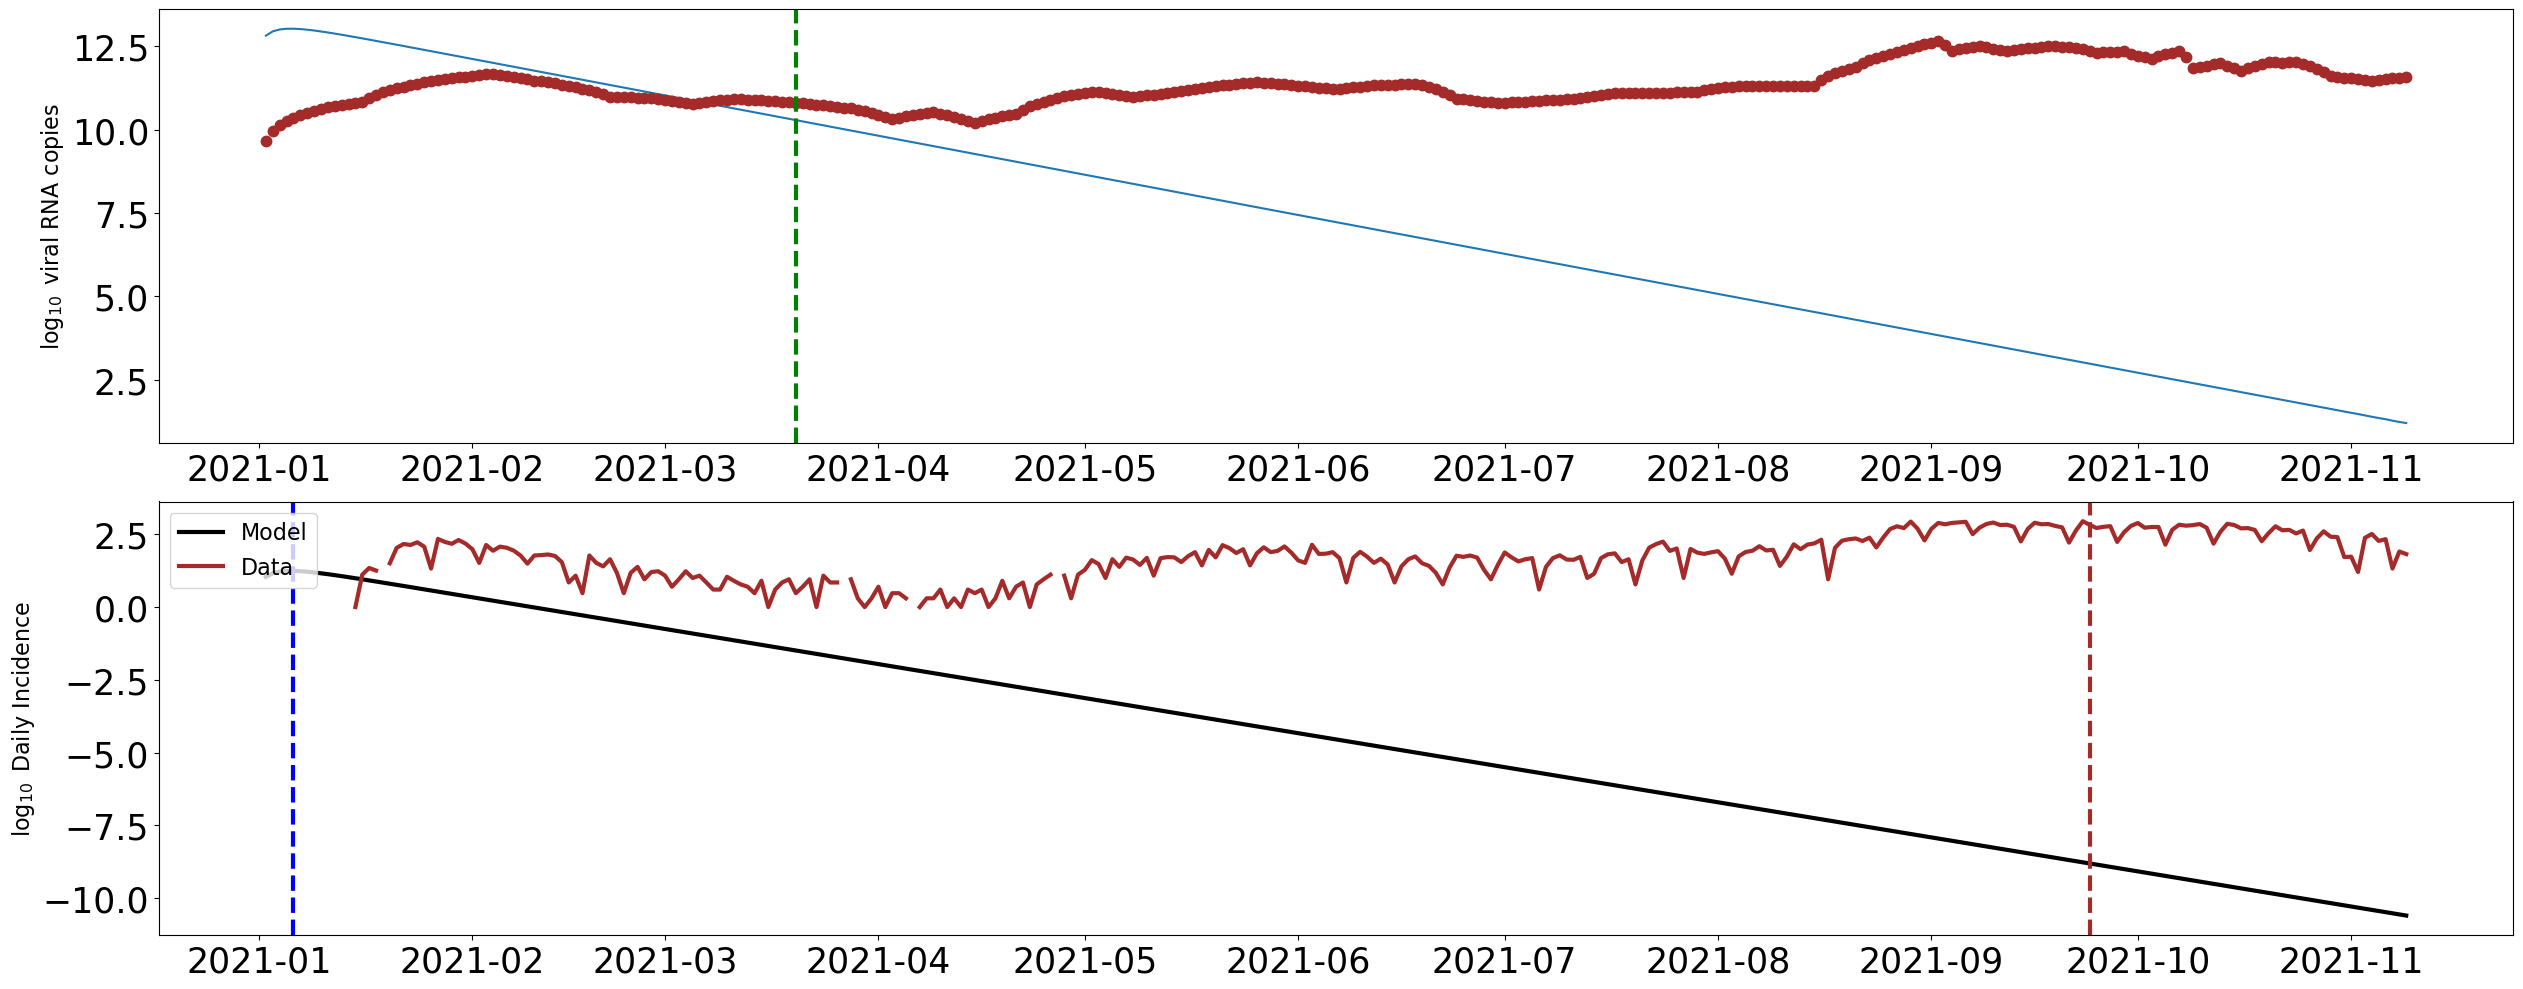

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

newRepCases2=data['cases'][:313]
time = [datetime(2021,1,1) + timedelta(days=i) for i in range(len(V1))]
time2 = time[1:]

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
ax1.plot(time2, np.log10(np.diff([array_[4] for array_ in Y])))
ax1.plot(time2, np.log10(V1[1:]), '.', markersize=15, color='brown', linewidth=3)
ax1.set_ylabel(r'$\log_{10}$ viral RNA copies')
ax1.axvline(datetime(2021,1,1) + timedelta(days=split), color='g', linestyle='--', linewidth=3)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)

ax2.plot(time[1:], np.log10(np.diff([array_[5] for array_ in Y])), 'k-', linewidth=3)
p2 = ax2.plot(time2, np.log10(newRepCases2[1:]), 'brown', linewidth=3)
ax2.set_ylabel(r'$\log_{10}$ Daily Incidence')
ax2.axvline(time2[np.argmax(np.diff([array_[5] for array_ in Y]))], color='b', linestyle='--', linewidth=3)
ax2.axvline(time2[np.argmax(newRepCases2)], color='brown', linestyle='--', linewidth=3)
ax2.legend(['Model', 'Data'], loc='upper left')
ax2.tick_params(axis='x', labelsize=25)
ax2.tick_params(axis='y', labelsize=25)
plt.tight_layout()
plt.savefig('卢森堡最小二乘拟合.pdf', format='pdf', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

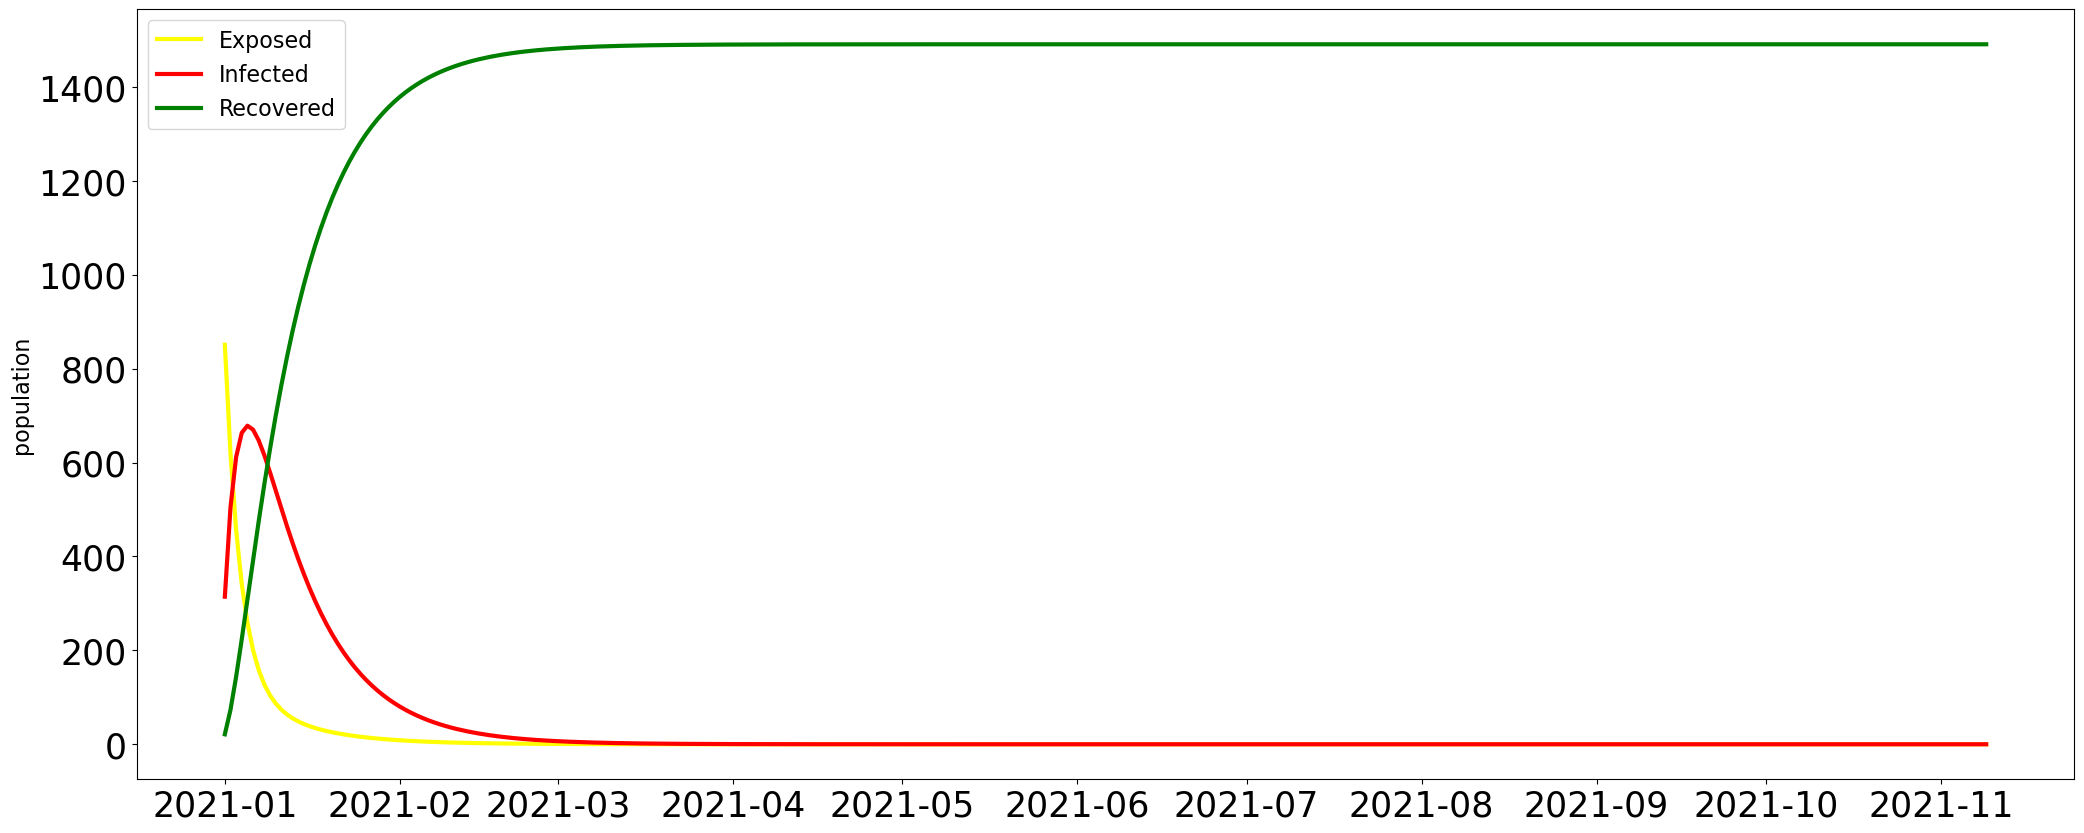

In [29]:
plt.figure()
fig, (ax1) = plt.subplots(1, 1, figsize=(25, 10))
ax1.plot(time, [array_[1] for array_ in Y],color='yellow', linewidth=3,label='Exposed')
ax1.plot(time, [array_[2] for array_ in Y],color='red', linewidth=3,label='Infected')
ax1.plot(time, [array_[3] for array_ in Y],color='green', linewidth=3,label='Recovered')
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
plt.ylabel('population')
plt.legend()
plt.savefig('卢森堡最小二乘SEIR.pdf', format='pdf', dpi=300)
plt.show()

r_squared = 0.030138131580799477


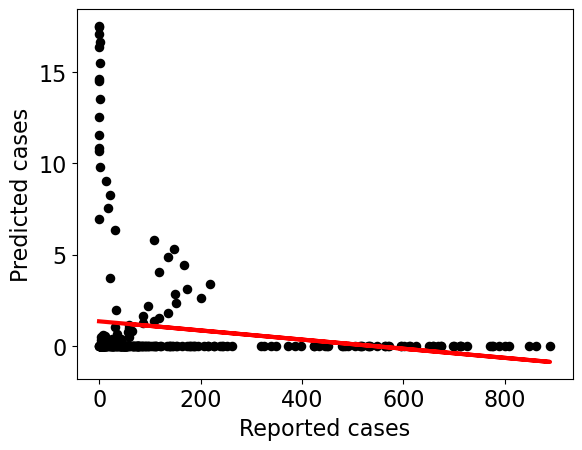

In [30]:
import numpy as np
import matplotlib.pyplot as plt
# 创建新的图形窗口
plt.figure()

# 计算 y 和 x
y = np.diff([array_[5] for array_ in Y])
x = newRepCases2[1:]

# 创建设计矩阵
X = np.column_stack((np.ones_like(x), x))

# 使用最小二乘法计算系数
b = np.linalg.lstsq(X, y, rcond=None)[0]

# 计算预测值
y_calc2 = np.dot(X, b)

# 绘制散点图和拟合直线
plt.scatter(x, y, s=15, color='k', linewidths=3)
plt.plot(x, y_calc2, 'r', linewidth=3)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
plt.ylabel('Predicted cases')
plt.xlabel('Reported cases')
plt.savefig('卢森堡最小二乘相关性分析.pdf', format='pdf', dpi=300)
# 计算 R 平方
r_squared = 1 - np.sum((y - y_calc2) ** 2) / np.sum((y - np.mean(y)) ** 2)
print('r_squared =', r_squared)
# 计算相关系数
#r = np.corrcoef(x, y)[0, 1]

[7.90326222 0.01654095 0.90602343 9.88969982]


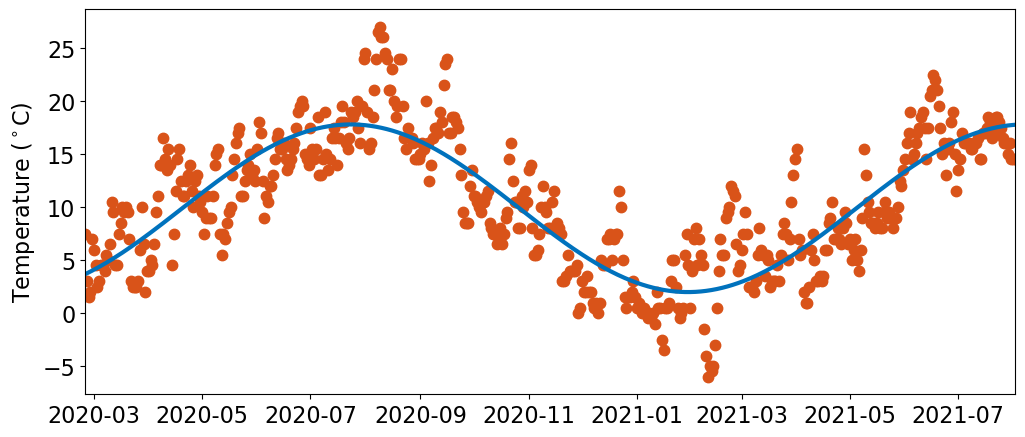

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
'''
获取温度随时间变量拟合的最佳模型
参数：

'''
# 设置随机数种子
np.random.seed(0)

# 设置绘图样式
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

# 颜色定义
bl = '#0072BD'
br = '#D95319'

# 加载数据
data = pd.read_excel('./LuxembourgT.xlsx')
xdata = np.arange(len(data['T-max']))
Tmax = np.array([float(temp.replace('°', '')) for temp in data['T-max']])
Tmin = np.array([float(temp.replace('°', '')) for temp in data['T-min']])
ydata = (Tmax+Tmin)*0.5
ydata = np.squeeze(ydata)

# 定义拟合函数
def func(xdata, A, B, C, D):
    return A * np.sin(B * xdata - C) + D

# 设置初始猜测值
p0 = [4, 0.02, 0, 15]

# 执行曲线拟合
params, pcov = curve_fit(func, xdata, ydata, p0)
y=func(xdata, params[0], params[1], params[2], params[3])
print(params)
xdata = [datetime(2020,2,25) + timedelta(days=i) for i in range(len(data['T-max']))]
# 绘制图像
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(xdata, ydata, '.', markersize=15, color=br)

ax.plot(xdata, y, linewidth=3, color=bl)
ax.set_xlim(xdata[0], xdata[-1])
ax.set_ylabel(r'Temperature ($^\circ$C)')
plt.savefig('卢森堡温度.pdf', format='pdf', dpi=300)
plt.show()